# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import LongType
#from pyspark.sql.functions import year, month, dayofmonth, hour
from pyspark.sql import Window
from pyspark.sql.functions import when, rand, mean, split, explode, max as maximum,min as minimum,datediff,from_unixtime, countDistinct as addupDistinct, sum as total, date_add

import datetime as dt

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify app") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
# check schema of data
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# check what types of pages exist
user_log.groupBy('page').count().orderBy(desc('count')).show(50)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



Plot visualizations of page types frequencies

In [6]:
activity_df = user_log.groupBy('page').count().orderBy(desc('count')).toPandas()

In [7]:
activity_df['count_percentage'] = activity_df['count']/activity_df['count'].sum()*100

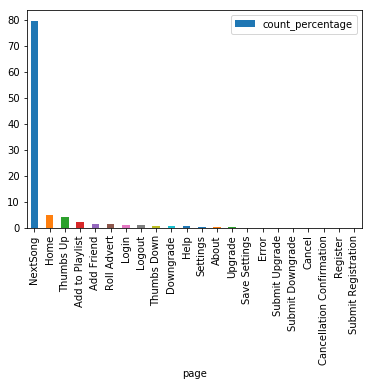

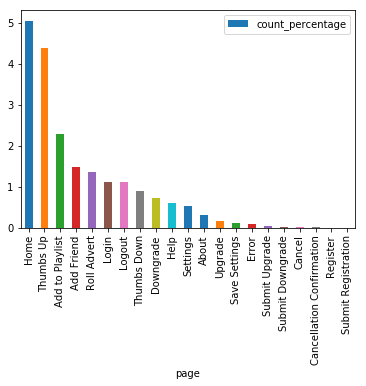

In [8]:
def plot_figures(activity_df):
    activity_df.plot(x='page',y='count_percentage',kind='bar')
    plt.show()
    activity_df[activity_df['page'] != 'NextSong'].plot(x='page',y='count_percentage',kind='bar')
    plt.show()
    
plot_figures(activity_df)

In [9]:
# filter out null and empty ids
user_log = user_log.filter(user_log.userId != "")\
                    .filter(user_log.userId.isNotNull())\
                    .filter(user_log.sessionId.isNotNull())

In [10]:
# select particular columns to continue with
selected_data = user_log.select(['sessionId','userId',\
                                'song','artist', 'gender','itemInSession',\
                                'length','level','location','page','status','ts','userAgent'])

In [11]:
selected_data.select('level','status','itemInSession','userAgent','page','sessionId','length').show(10)

+-----+------+-------------+--------------------+---------------+---------+---------+
|level|status|itemInSession|           userAgent|           page|sessionId|   length|
+-----+------+-------------+--------------------+---------------+---------+---------+
| paid|   200|           50|Mozilla/5.0 (Wind...|       NextSong|       29|277.89016|
| free|   200|           79|"Mozilla/5.0 (Win...|       NextSong|        8|236.09424|
| paid|   200|           51|Mozilla/5.0 (Wind...|       NextSong|       29| 282.8273|
| free|   200|           80|"Mozilla/5.0 (Win...|       NextSong|        8|262.71302|
| paid|   200|           52|Mozilla/5.0 (Wind...|       NextSong|       29|223.60771|
| free|   200|           81|"Mozilla/5.0 (Win...|       NextSong|        8|208.29995|
| free|   200|           82|"Mozilla/5.0 (Win...|       NextSong|        8|260.46649|
| paid|   200|           53|Mozilla/5.0 (Wind...|       NextSong|       29|185.44281|
| paid|   200|           54|Mozilla/5.0 (Wind...|Add t

Create new columns to infer year, month, day and hour from timestamp

In [12]:
# create timestamp udfs
get_hour = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).hour)
get_year = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).year)
get_month = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).month)
get_day = udf(lambda x: dt.datetime.fromtimestamp(x / 1000.0).day)

In [13]:
selected_data = selected_data.withColumn('year',get_year(selected_data.ts))\
                            .withColumn('month',get_month(selected_data.ts))\
                            .withColumn('day',get_day(selected_data.ts))\
                            .withColumn('hour',get_hour(selected_data.ts))\

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**Create user defined UDFs to extract features for modeling**

In [14]:
check_for_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
check_for_downgrade_visit = udf(lambda x: 1 if x == 'Downgrade' else 0, IntegerType())
check_for_downgrade_submit = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
check_for_playlist = udf(lambda x: 1 if x == 'Add to Playlist' else 0, IntegerType())
check_for_friends = udf(lambda x: 1 if x == 'Add Friend' else 0, IntegerType())
check_for_adverts = udf(lambda x: 1 if x == 'Roll Advert' else 0, IntegerType())
check_for_logout = udf(lambda x: 1 if x == 'Logout' else 0, IntegerType())
# mark listening to song event
song_event = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
# mark listening to song event
check_level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
check_thumbsup = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())
check_thumbsdown = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())

In [15]:
windowsum = Window.partitionBy("userId")

**Generate binary user activity features on the basis of values of page column using previously defined UDFs**

In [16]:
# calculate start and end time for each user in the database
selected_data = selected_data.withColumn('endDate',from_unixtime(maximum(selected_data.ts/1000.0).over(windowsum)))\
                             .withColumn('startDate',from_unixtime(minimum(selected_data.ts/1000.0).over(windowsum)))

# calculate duration per user
selected_data = selected_data\
        .withColumn('durationDays',datediff('endDate','startDate'))

In [17]:
# adding weekly timestamps to track behaviour over time
selected_data = selected_data.withColumn('weekBeforeEndDate', date_add(selected_data.endDate,-7))\
                                .withColumn('twoweekBeforeEndDate', date_add(selected_data.endDate,-14))\
                                .withColumn('threeweekBeforeEndDate', date_add(selected_data.endDate,-21))\
                                .withColumn('fourweekBeforeEndDate', date_add(selected_data.endDate,-28))

In [18]:
selected_data = selected_data.withColumn('churn',check_for_churn('page'))\
                            .withColumn('downgradeVisit',check_for_downgrade_visit('page'))\
                            .withColumn('downgradeSubmit',check_for_downgrade_submit('page'))\
                            .withColumn('addToPlaylist',check_for_playlist('page'))\
                            .withColumn('addFriend',check_for_friends('page'))\
                            .withColumn('rollAdvert',check_for_adverts('page'))\
                            .withColumn('logout',check_for_logout('page'))\
                            .withColumn('payingUser',check_level('level'))\
                            .withColumn('Up',check_thumbsup('page'))\
                            .withColumn('Down',check_thumbsdown('page'))\
                            .withColumn('listeningSongs',song_event(selected_data.page))

**Create a column churned to mark user that churned as 1 and users that remianed as 0**

In [19]:
selected_data = selected_data.withColumn('churned',total('churn').over(windowsum))

**Filter data into two additional dataframes based on timestamp: last week of user activity in the sample
    and a week before the last. This will help to study user behaviour changes trhough time**

In [20]:
# filter out last week of user interactions
selected_data_last_week = selected_data\
                            .filter(from_unixtime(selected_data.ts/1000.0) > selected_data.weekBeforeEndDate)
selected_data_before_last_week = selected_data\
                            .filter(from_unixtime(selected_data.ts/1000.0) < selected_data.weekBeforeEndDate)

**Create additional UDFs to generate user features based on their acitivity.
These features will be used to train the model**

In [21]:
def calculate_total_user_activity(df):
    # find how much time canceling users were subscribed
    windowsum = Window.partitionBy("userId")

    # mark all instances of users that canceled subscription
    df = df.withColumn('downgradeVisited',total('downgradeVisit').over(windowsum))\
                        .withColumn('downgradeSubmitted',total('downgradeSubmit').over(windowsum))\

    
    # calculate total songs listened per user
    df = df.withColumn('songsListened', total('listeningSongs').over(windowsum))
    df = df.withColumn('songsAddedToPlaylist', total('addToPlaylist').over(windowsum))
    df = df.withColumn('friendsAdded', total('addFriend').over(windowsum))
    df = df.withColumn('rolledAdverts', total('rollAdvert').over(windowsum))
    df = df.withColumn('logouts', total('logout').over(windowsum))
    df = df.withColumn('DownVoted', total('Down').over(windowsum))
    df = df.withColumn('UpVoted', total('Up').over(windowsum))
    
    return df

In [22]:
def calculate_days_of_actual_interaction(df):
    days_interacting_per_user = df.select('userId','year','month','day').dropDuplicates()\
                            .groupBy('userId').count().withColumnRenamed('count','daysInteracting')
    df = df.join(days_interacting_per_user,'userId','left')
    
    return df

UDFs to calculate user activity per day and per song

In [23]:
def calculate_user_activity_per_day(df):
    # calculate average amount of songs listened per user
    df = df.withColumn('songsListenedPerDay'\
                                             , df.songsListened/df.daysInteracting)
    # calculate average amount of songs listened per user
    df = df.withColumn('songsAddedToPlaylistPerDay'\
                                             , df.songsAddedToPlaylist/df.daysInteracting)
    # calculate average amount of songs listened per user
    df = df.withColumn('friendsAddedPerDay'\
                                             , df.friendsAdded/df.daysInteracting)
    # calculate average amount of songs listened per user
    df = df.withColumn('rolledAdvertsPerDay'\
                                             , df.rolledAdverts/df.daysInteracting)
    # calculate average amount of songs listened per user
    df = df.withColumn('logoutsPerDay'\
                                             , df.logouts/df.daysInteracting)
    df = df.withColumn('upVotedPerDay'\
                                             , df.UpVoted/df.daysInteracting)
    df = df.withColumn('DownVotedPerDay'\
                                             , df.DownVoted/df.daysInteracting)
    df = df.withColumn('DownVotedPerSong'\
                                             , df.DownVoted/df.songsListened)
    df = df.withColumn('UpVotedPerSong'\
                                             , df.UpVoted/df.songsListened)
    df = df.withColumn('rolledAdvertsPerSong'\
                                             , df.rolledAdverts/df.songsListened)
    
    return df


Apply UDFs to three datasets to generate user activity features per day and per song

In [24]:
selected_data = calculate_total_user_activity(selected_data)
selected_data_last_week = calculate_total_user_activity(selected_data_last_week)
selected_data_before_last_week = calculate_total_user_activity(selected_data_before_last_week)

In [25]:
selected_data = calculate_days_of_actual_interaction(selected_data)
selected_data_last_week = calculate_days_of_actual_interaction(selected_data_last_week)
selected_data_before_last_week = calculate_days_of_actual_interaction(selected_data_before_last_week)

In [26]:
selected_data = calculate_user_activity_per_day(selected_data)
selected_data_last_week = calculate_user_activity_per_day(selected_data_last_week)
selected_data_before_last_week = calculate_user_activity_per_day(selected_data_before_last_week)

In [27]:
selected_data = selected_data.withColumn('intensityOfInteraction',\
                                         selected_data.daysInteracting/selected_data.durationDays*100)\
                             .fillna(0,subset=['intensityOfInteraction'])

**Generate aggregations to study the differences between churned and remaining users to select features for the model**

In [28]:
if False:
    selected_data.count()

In [29]:
if False:
    selected_data.select('userId').dropDuplicates().count()

In [30]:
if False:
    selected_data.select(['year','month','day']).dropDuplicates().count()

In [31]:
if False:
    selected_data_last_week.select(['userId','churned','songsListenedPerDay'\
                                             , 'songsAddedToPlaylistPerDay'
                                             , 'friendsAddedPerDay'
                                             , 'rolledAdvertsPerDay'
                                             , 'logoutsPerDay'
                                             , 'upVotedPerDay'
                                             , 'DownVotedPerDay'
                                             , 'DownVotedPerSong'
                                             , 'UpVotedPerSong'
                                             , 'rolledAdvertsPerSong'])\
                                            .dropDuplicates()\
                                            .groupBy('churned')\
                                            .avg('songsListenedPerDay'
                                                 , 'songsAddedToPlaylistPerDay'
                                                 , 'friendsAddedPerDay'
                                                 , 'rolledAdvertsPerDay').show()

In [32]:
if False:
    selected_data_before_last_week.select(['userId','churned','songsListenedPerDay'\
                                             , 'songsAddedToPlaylistPerDay'
                                             , 'friendsAddedPerDay'
                                             , 'rolledAdvertsPerDay'
                                             , 'logoutsPerDay'
                                             , 'upVotedPerDay'
                                             , 'DownVotedPerDay'
                                             , 'DownVotedPerSong'
                                             , 'UpVotedPerSong'
                                             , 'rolledAdvertsPerSong'])\
                                            .dropDuplicates()\
                                            .groupBy('churned')\
                                            .avg('songsListenedPerDay'
                                                 , 'songsAddedToPlaylistPerDay'
                                                 , 'friendsAddedPerDay'
                                                 , 'rolledAdvertsPerDay').show()

In [33]:
if False:
    selected_data_last_week.select(['userId','churned','songsListenedPerDay'\
                                             , 'songsAddedToPlaylistPerDay'
                                             , 'friendsAddedPerDay'
                                             , 'rolledAdvertsPerDay'
                                             , 'logoutsPerDay'
                                             , 'upVotedPerDay'
                                             , 'DownVotedPerDay'
                                             , 'DownVotedPerSong'
                                             , 'UpVotedPerSong'
                                             , 'rolledAdvertsPerSong'])\
                                            .dropDuplicates()\
                                            .groupBy('churned')\
                                            .avg('logoutsPerDay'
                                                 , 'DownVotedPerSong'
                                                 , 'UpVotedPerSong'
                                                 , 'rolledAdvertsPerSong').show()

In [34]:
if False:
    selected_data_before_last_week.select(['userId','churned','songsListenedPerDay'\
                                             , 'songsAddedToPlaylistPerDay'
                                             , 'friendsAddedPerDay'
                                             , 'rolledAdvertsPerDay'
                                             , 'logoutsPerDay'
                                             , 'upVotedPerDay'
                                             , 'DownVotedPerDay'
                                             , 'DownVotedPerSong'
                                             , 'UpVotedPerSong'
                                             , 'rolledAdvertsPerSong'])\
                                            .dropDuplicates()\
                                            .groupBy('churned')\
                                            .avg('logoutsPerDay'
                                                 , 'DownVotedPerSong'
                                                 , 'UpVotedPerSong'
                                                 , 'rolledAdvertsPerSong').show()

In [35]:
# keep only distinct user calculations
selected_data_last_week = selected_data_last_week.select(['userId','songsListenedPerDay','songsAddedToPlaylistPerDay']).dropDuplicates()
selected_data_before_last_week = selected_data_before_last_week.select(['userId','songsListenedPerDay','songsAddedToPlaylistPerDay']).dropDuplicates()

selected_data_last_week = selected_data_last_week\
                            .withColumnRenamed('songsAddedToPlaylistPerDay','songsAddedToPlaylistPerDayLastWeek')\
                            .withColumnRenamed('songsListenedPerDay','songsListenedPerDayLastWeek')

selected_data_before_last_week = selected_data_before_last_week\
                            .withColumnRenamed('songsAddedToPlaylistPerDay','songsAddedToPlaylistPerDayBeforeLastWeek')\
                            .withColumnRenamed('songsListenedPerDay','songsListenedPerDayBeforeLastWeek')

In [36]:
selected_data = selected_data.join(selected_data_last_week\
                    .select(['userId'\
                             ,'songsAddedToPlaylistPerDayLastWeek'\
                             ,'songsListenedPerDayLastWeek']),'userId','left')

In [37]:
selected_data = selected_data.join(selected_data_before_last_week\
                    .select(['userId'\
                             ,'songsAddedToPlaylistPerDayBeforeLastWeek'\
                             ,'songsListenedPerDayBeforeLastWeek']),'userId','left')

In [38]:
selected_data = selected_data.withColumn('playlistActivityChange'\
                                          ,selected_data.songsAddedToPlaylistPerDayLastWeek/selected_data.songsAddedToPlaylistPerDayBeforeLastWeek)\
                             .withColumn('listeningActivityChange'\
                                          ,selected_data.songsListenedPerDayLastWeek/selected_data.songsListenedPerDayBeforeLastWeek)

In [39]:
if False:
    selected_data.select(['userId','churned', 'intensityOfInteraction'])\
                                            .dropDuplicates()\
                                            .groupBy('churned')\
                                            .avg('intensityOfInteraction').show()

In [40]:
if False:
    selected_data.select(['userId','churned','songsListenedPerDay'\
                                             , 'songsAddedToPlaylistPerDay'
                                             , 'friendsAddedPerDay'
                                             , 'rolledAdvertsPerDay'
                                             , 'logoutsPerDay'
                                             , 'upVotedPerDay'
                                             , 'DownVotedPerDay'
                                             , 'DownVotedPerSong'
                                             , 'UpVotedPerSong'
                                             , 'rolledAdvertsPerSong'])\
                                            .dropDuplicates()\
                                            .groupBy('churned')\
                                            .avg('songsListenedPerDay'
                                                 , 'songsAddedToPlaylistPerDay'
                                                 , 'friendsAddedPerDay'
                                                 , 'rolledAdvertsPerDay').show()

In [41]:
if False:
    selected_data.select(['userId','churned','songsListenedPerDay'\
                                             , 'songsAddedToPlaylistPerDay'
                                             , 'friendsAddedPerDay'
                                             , 'rolledAdvertsPerDay'
                                             , 'logoutsPerDay'
                                             , 'upVotedPerDay'
                                             , 'DownVotedPerDay'
                                             , 'DownVotedPerSong'
                                             , 'UpVotedPerSong'
                                             , 'rolledAdvertsPerSong'])\
                                            .dropDuplicates()\
                                            .groupBy('churned')\
                                            .avg('logoutsPerDay'
                                                 , 'DownVotedPerSong'
                                                 , 'UpVotedPerSong'
                                                 , 'rolledAdvertsPerSong').show()

In [42]:
selected_data_distinct_users = selected_data.select(['userId'\
                                                     ,'churned'\
                                                     ,'songsListenedPerDay'\
                                                     ,'DownVotedPerSong'\
                                                     ,'friendsAddedPerDay'\
                                                     ,'intensityOfInteraction'\
                                                     ,'playlistActivityChange'\
                                                     ,'listeningActivityChange']).dropDuplicates()

Replace null values for features where denominators were zeros (days of app usage or songs listened were 0) so per
day and per song values are nulls

In [43]:
selected_data_distinct_users = selected_data_distinct_users.fillna(0,subset=['songsListenedPerDay'\
                                                     ,'DownVotedPerSong'\
                                                     ,'friendsAddedPerDay'\
                                                     ,'intensityOfInteraction'\
                                                     ,'playlistActivityChange'\
                                                     ,'listeningActivityChange'])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**Select final features for modeling and transform the dataframe into the specified form**

In [44]:
data = selected_data_distinct_users.select(['churned'\
                                                     ,'songsListenedPerDay'\
                                                     ,'DownVotedPerSong'\
                                                     ,'friendsAddedPerDay'\
                                                     ,'intensityOfInteraction'\
                                                     ,'playlistActivityChange'\
                                                     ,'listeningActivityChange'])\
                                   .withColumnRenamed('churned','label')

In [45]:
assembler = VectorAssembler(inputCols=["songsListenedPerDay"\
                                       , "DownVotedPerSong"
                                       , 'friendsAddedPerDay'
                                       , 'intensityOfInteraction'
                                       , 'playlistActivityChange'
                                       ,'listeningActivityChange'], outputCol="features")

In [46]:
data = assembler.transform(data)

In [47]:
data = data.select(['label','features'])

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [48]:
# Split data into training and testing sets
trainingData, testData = data.randomSplit([0.7, 0.3], seed=12345)

In [70]:
trainingData.agg(mean('label')).show()

+-------------------+
|         avg(label)|
+-------------------+
|0.20958083832335328|
+-------------------+



In [71]:
testData.agg(mean('label')).show()

+-------------------+
|         avg(label)|
+-------------------+
|0.29310344827586204|
+-------------------+



**Run logistic regression and decision tree algos to train the model**

In [49]:
# instanciate the linear regression model
lr = LogisticRegression(maxIter=5, regParam=0.0)
dtr = DecisionTreeClassifier(labelCol="label", featuresCol="features")


In [50]:
# Define a grid of hyperparameters to search over
paramGrid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [4, 6]) \
    .build()

In [51]:
# Evaluate the predictions using F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
# Create a CrossValidator to perform grid search
cv = CrossValidator(estimator=dtr, estimatorParamMaps=paramGrid, evaluator=evaluator)

In [52]:
# Fit the CrossValidator to the training data
dt_cvModel = cv.fit(trainingData)

In [53]:
bestModel = dt_cvModel.bestModel

# Print the best parameters
print("Best parameters:")
for param, value in bestModel.extractParamMap().items():
    print("{}: {}".format(param.name, value))

Best parameters:
cacheNodeIds: False
checkpointInterval: 10
featuresCol: features
impurity: gini
labelCol: label
maxBins: 32
maxDepth: 4
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 6749696999409305773


In [54]:
dt_model = dtr.fit(trainingData)

In [55]:
lr_model = lr.fit(trainingData)

In [56]:
# use test data to make predictions
lr_predictions = lr_model.transform(testData)
# Evaluate the best model on the test data
dt_predictions = dt_model.transform(testData)

In [57]:
bestModel_predictions = bestModel.transform(testData)

In [58]:
dt_f1_score = evaluator.evaluate(dt_predictions)
lr_f1_score = evaluator.evaluate(lr_predictions)

In [59]:
bestModel_f1_score = evaluator.evaluate(bestModel_predictions)

In [60]:
print(dt_f1_score)
print(lr_f1_score)
print(bestModel_f1_score)

0.7994451050336902
0.7081971586740479
0.6939581491305629


In [62]:
# Create a dictionary with the column names and values
scores = {'LR f1 score': [lr_f1_score],
         'DT default maxDepth of 5': [dt_f1_score],
         'DT maxDepth of 4': [bestModel_f1_score]}

# Create a DataFrame from the dictionary
scores = pd.DataFrame(scores)

# Display the DataFrame
print(scores)

   LR f1 score  DT default maxDepth of 5  DT maxDepth of 4
0     0.708197                  0.799445          0.693958


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.